In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

import os
import sys
path = os.getcwd()+'/drive/MyDrive/NSSP_Project2/'
sys.path.append(os.getcwd()+'/drive/MyDrive/NSSP_Project2/')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0.Load Data

In [3]:
# load EMG data
EMG_file_name='s1/S1_A1_E1.mat'
emg_data = loadmat(path+EMG_file_name)
print(emg_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'emg', 'stimulus', 'glove', 'subject', 'exercise', 'repetition', 'restimulus', 'rerepetition'])


In [36]:
glove = emg_data["glove"].copy()
extract_list = [3, 6, 8, 11, 14]
angle = glove[:, extract_list]
emg = emg_data["emg"].copy()
print(f'angle.shape={angle.shape}, emg={emg.shape}')
stimulus = emg_data["restimulus"]
repetition = emg_data["rerepetition"]
print(f'angle.shape={angle.shape}, emg={emg.shape}, stimulus={stimulus.shape}, repetition={repetition.shape}')

(101014, 10)


IndexError: index 11 is out of bounds for axis 1 with size 10

# 1. Preprocessing

In [5]:
def build_dataset_from_ninapro(emg, stimulus, repetition, features=None):
    # Calculate the number of unique stimuli and repetitions, subtracting 1 to exclude the resting condition
    n_stimuli = np.unique(stimulus).size - 1
    n_repetitions = np.unique(repetition).size - 1
    # Total number of samples is the product of stimuli and repetitions
    n_samples = n_stimuli * n_repetitions

    # Number of channels in the EMG data
    n_channels = emg.shape[1]
    # Calculate the total number of features by summing the number of channels for each feature
    n_features = sum(n_channels for feature in features)

    # Initialize the dataset and labels arrays with zeros
    dataset = np.zeros((n_samples, n_features))
    labels = np.zeros(n_samples)
    current_sample_index = 0

    # Loop over each stimulus and repetition to extract features
    for i in range(n_stimuli):
        for j in range(n_repetitions):
            # Assign the label for the current sample
            labels[current_sample_index] = i + 1
            # Calculate the current sample index based on stimulus and repetition
            current_sample_index = i * n_repetitions + j
            current_feature_index = 0
            # Select the time steps corresponding to the current stimulus and repetition
            selected_tsteps = np.logical_and(stimulus == i + 1, repetition == j + 1).squeeze()

            # Loop over each feature function provided
            for feature in features:
                # Determine the indices in the dataset where the current feature will be stored
                selected_features = np.arange(current_feature_index, current_feature_index + n_channels)
                # Apply the feature function to the selected EMG data and store the result
                dataset[current_sample_index, selected_features] = feature(emg[selected_tsteps, :])
                # Update the feature index for the next feature
                current_feature_index += n_channels

            # Move to the next sample
            current_sample_index += 1

    # Return the constructed dataset and corresponding labels
    return dataset, labels

## 1.1 Apply bandpass filter
Before preprocessing, we visualize the rawdata for subject2.

In [6]:
n_channels = emg.shape[1]

fs = 2000 # According to the references, sampling frequency here is 2000 Hz.

time_steps = np.arange(0,emg.shape[0]/fs, 1/fs)

# bandpass
bandpass_cutoff_frequencies_Hz = (15, 500)
sos = butter(N=0, Wn=bandpass_cutoff_frequencies_Hz, fs=fs, btype="bandpass", output="sos")
emg_filtered = sosfiltfilt(sos, emg.T).T

powergrid_noise_frequencies_Hz = [harmonic_idx*50 for harmonic_idx in range(1,3)] # removing 50Hz noise and its harmonics

for noise_frequency in powergrid_noise_frequencies_Hz:
    sos = butter(N=4, Wn=(noise_frequency - 2, noise_frequency + 2), fs=fs, btype="bandstop", output="sos")
    emg_filtered = sosfiltfilt(sos, emg_filtered.T).T

# rectify signals
emg_rectified = np.abs(emg_filtered)

In [7]:
# -1 because 0 is the resting condition
n_stimuli = len(np.unique(stimulus)) - 1
# -1 because 0 is not a repetition
n_repetitions = len(np.unique(repetition)) - 1
n_channels = emg_rectified.shape[1]

print(f'How many types of movement are there? {n_stimuli}')
print(f'How many repetitions are there? {n_repetitions}')

How many types of movement are there? 12
How many repetitions are there? 10


In [8]:
number_of_samples_per_trial = np.zeros((n_stimuli, n_repetitions))

for stimuli_idx in range(n_stimuli):
    for repetition_idx in range(n_repetitions):

        idx = np.logical_and(stimulus == stimuli_idx+1, repetition == repetition_idx+1)
        number_of_samples_per_trial[stimuli_idx, repetition_idx] = np.sum(idx.astype(int))

number_of_samples_per_trial

array([[305., 354., 346., 371., 438., 372., 430., 412., 435., 352.],
       [193., 388., 233., 234., 244., 252., 316., 227., 229., 302.],
       [524., 390., 481., 433., 460., 515., 199., 360., 424., 356.],
       [348., 296., 287., 276., 281., 242., 278., 315., 330., 329.],
       [452., 453., 382., 416., 376., 418., 430., 339., 318., 368.],
       [293., 305., 432., 286., 301., 306., 254., 299., 253., 329.],
       [246., 240., 266., 263., 252., 187., 259., 325., 299., 278.],
       [211., 294., 277., 359., 333., 372., 374., 287., 306., 185.],
       [197., 250., 234., 222., 295., 281., 269., 330., 289., 241.],
       [458., 184., 184., 270., 407., 188., 338., 379., 473., 306.],
       [186., 285., 305., 195., 230., 240., 222., 318., 238., 272.],
       [341., 429., 189., 239., 526., 261., 185., 521., 224., 319.]])

# Normalization and Feature Extraction

In [14]:
def compute_features(emg_signal, window_width, sliding_step):
    """
    Calculate the feature of the sliding window of the EMG signals
    :param emg_signal: input signals (time_sequences, channels)
    :param window_width: the size of the window
    :param sliding_step: sliding steps
    :return: features (num_windows, channels * num_features)
    """
    num_samples, num_channels = emg_signal.shape
    num_features = 6  # MAV, STD, MaxAV, RMS, WL, SSC
    features = []

    for start in range(0, num_samples - window_width + 1, sliding_step):
        window = emg_signal[start:start + window_width, :]

        mav_vals = mav(window)
        std_vals = std(window)
        maxav_vals = maxav(window)
        rms_vals = rms(window)
        wl_vals = wl(window)
        ssc_vals = ssc(window)

        # concate the features
        window_features = np.hstack([mav_vals, std_vals, maxav_vals, rms_vals, wl_vals, ssc_vals])
        features.append(window_features)

    features = np.array(features)  
    return features

In [16]:
# Define the features
# Mean absolute value (MAV)
mav = lambda x: np.mean(np.abs(x), axis=0)
# Standard Deviation (STD)
std = lambda x: np.std(x, axis=0)
# Maximum absolute Value (MaxAV)
maxav = lambda x: np.max(np.abs(x), axis=0)
# Root mean square (RMS)
rms = lambda x: np.sqrt(np.mean(x**2, axis=0))
# Waveform length (WL)
wl = lambda x: np.sum(np.abs(np.diff(x, axis=0)), axis=0)
# Slope sign changes (SSC)
ssc = lambda x: np.sum((np.diff(x, axis=0)[:-1, :] * np.diff(x, axis=0)[1:, :]) < 0, axis=0)

window_width = 400  # 200 ms window
sliding_step = 100  # 50 ms step


In [17]:
print(emg_rectified.shape)
print(angle.shape)
features = compute_features(emg_rectified, window_width, sliding_step)

(101014, 10)
(101014, 5)


In [18]:
print(features.shape)

(1007, 60)


<ipython-input-22-f10db3c88e32>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


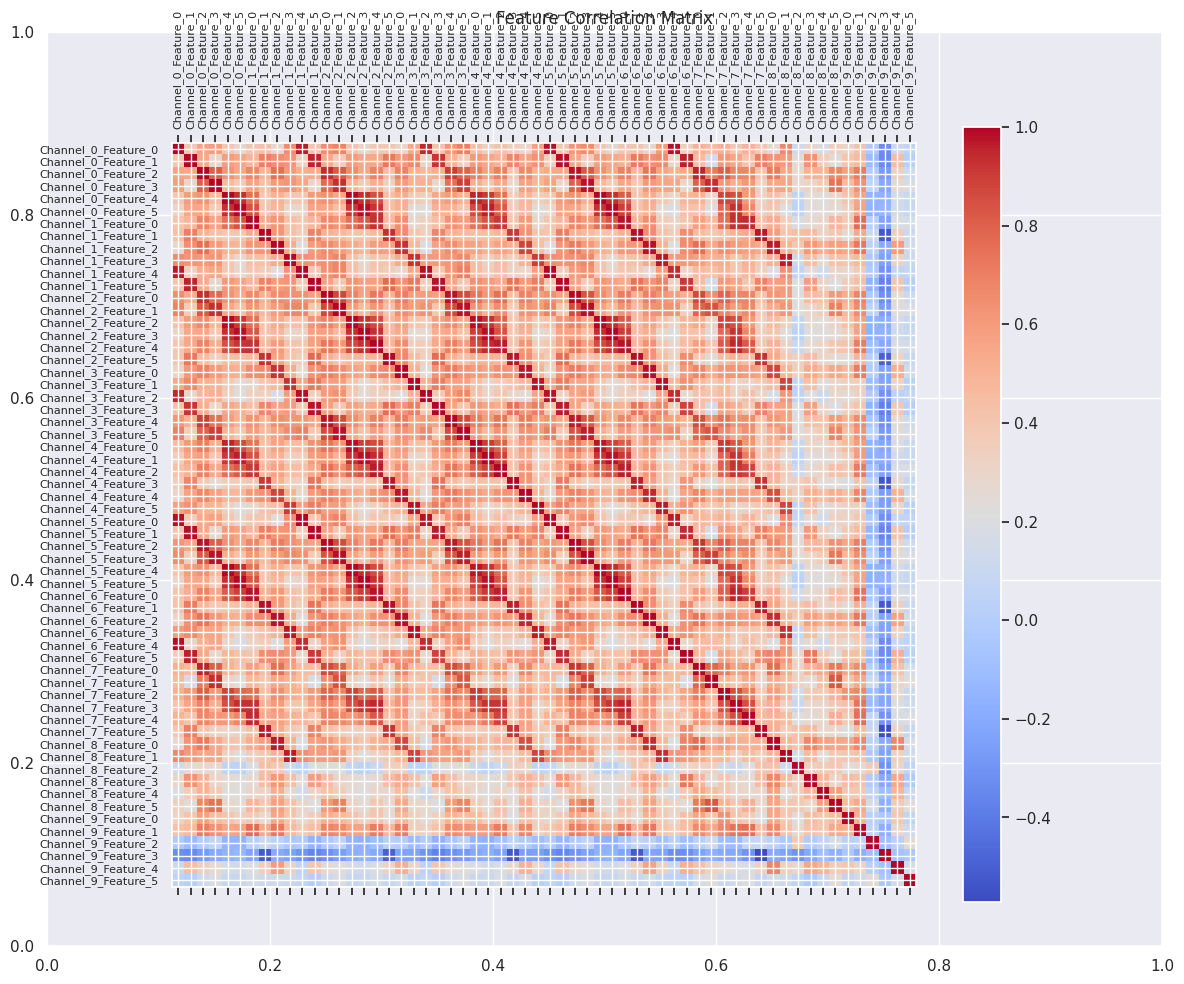

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假设 features 的形状为 (num_windows, channels * num_features)
num_windows, total_features = features.shape
channels = 10  # channels
num_features = total_features // channels  # 每个通道的特征数

# 重新组织成 (num_windows, channels, num_features)
reshaped_features = features.reshape(num_windows, channels, num_features)

# 计算特征之间的相关性
# 将通道维度拼接，分析每个特征在所有通道上的相关性
feature_names = [f"Feature_{i}" for i in range(num_features)]
channel_names = [f"Channel_{ch}" for ch in range(channels)]

# 合并成一个 DataFrame，方便计算
flattened_features = reshaped_features.reshape(num_windows, -1)  # 形状 (num_windows, channels * num_features)
flattened_columns = [f"{channel_names[ch]}_{feature_names[f]}" for ch in range(channels) for f in range(num_features)]
df_features = pd.DataFrame(flattened_features, columns=flattened_columns)

# 计算相关性矩阵
correlation_matrix = df_features.corr()

plt.figure(figsize=(12, 10))
plt.title("Feature Correlation Matrix")
cax = plt.matshow(correlation_matrix, cmap="coolwarm", fignum=1)
plt.colorbar(cax)
plt.xticks(range(len(flattened_columns)), flattened_columns, rotation=90, fontsize=8)
plt.yticks(range(len(flattened_columns)), flattened_columns, fontsize=8)
plt.tight_layout()
plt.show()


dataset.shape=(120, 60)
['MAV_1', 'MAV_2', 'MAV_3', 'MAV_4', 'MAV_5', 'MAV_6', 'MAV_7', 'MAV_8', 'MAV_9', 'MAV_10', 'STD_1', 'STD_2', 'STD_3', 'STD_4', 'STD_5', 'STD_6', 'STD_7', 'STD_8', 'STD_9', 'STD_10', 'MaxAV_1', 'MaxAV_2', 'MaxAV_3', 'MaxAV_4', 'MaxAV_5', 'MaxAV_6', 'MaxAV_7', 'MaxAV_8', 'MaxAV_9', 'MaxAV_10', 'RMS_1', 'RMS_2', 'RMS_3', 'RMS_4', 'RMS_5', 'RMS_6', 'RMS_7', 'RMS_8', 'RMS_9', 'RMS_10', 'WL_1', 'WL_2', 'WL_3', 'WL_4', 'WL_5', 'WL_6', 'WL_7', 'WL_8', 'WL_9', 'WL_10', 'SSC_1', 'SSC_2', 'SSC_3', 'SSC_4', 'SSC_5', 'SSC_6', 'SSC_7', 'SSC_8', 'SSC_9', 'SSC_10']


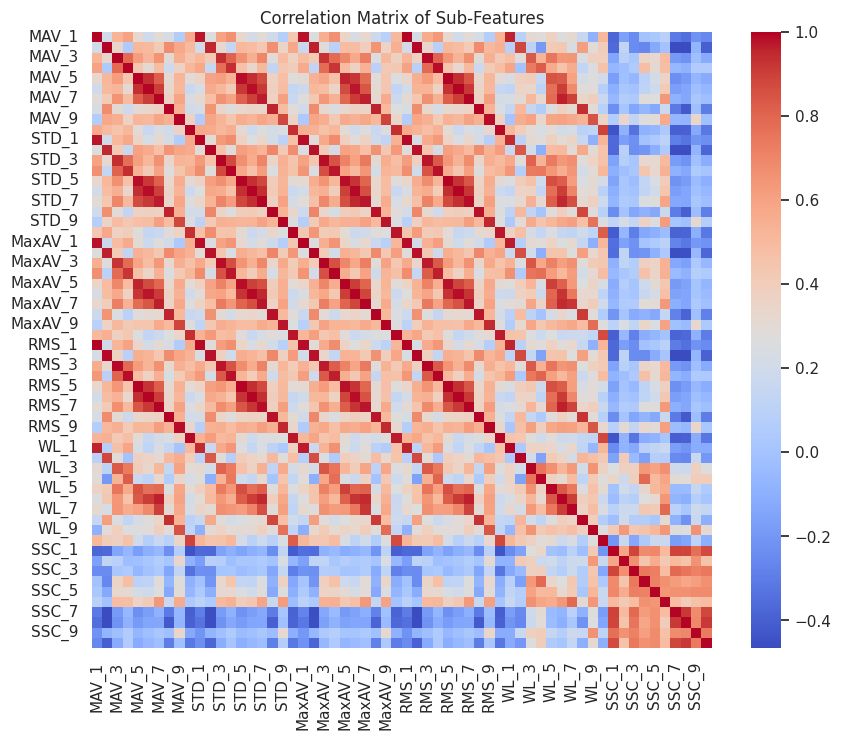

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Assuming `dataset` and `labels` are already built
feature_names = ["MAV", "STD", "MaxAV", "RMS", "WL", "SSC"]
expanded_feature_names = [f"{feature}_{i+1}" for feature in feature_names for i in range(10)]

# Convert dataset into a DataFrame for easy manipulation and visualization
print(f'dataset.shape={dataset.shape}')
print(expanded_feature_names)
df = pd.DataFrame(dataset, columns=expanded_feature_names)
df['Label'] = labels

# # 1. Distribution of each main feature (aggregate across sub-features)
# plt.figure(figsize=(16, 10))
# for i, feature in enumerate(feature_names):
#     sub_features = [f"{feature}_{j+1}" for j in range(5)]
#     aggregated_values = df[sub_features].mean(axis=1)  # Aggregate sub-feature values
#     plt.subplot(2, 3, i + 1)
#     sns.histplot(aggregated_values, kde=True, bins=30)
#     plt.title(f'Distribution of {feature} (Aggregated)')
# plt.tight_layout()
# plt.show()

# 2. Correlation Heatmap for all sub-features
plt.figure(figsize=(10, 8))
corr_matrix = df[expanded_feature_names].corr()
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap="coolwarm")  # Set `annot=True` for detailed values
plt.title("Correlation Matrix of Sub-Features")
plt.show()

# # 3. Pairplot for selected sub-features (if data size is manageable)
# # Use first sub-feature of each type for simplicity
# selected_features = [f"{feature}_1" for feature in feature_names]
# sns.pairplot(df, vars=selected_features, hue='Label', palette='tab10', diag_kind='kde')
# plt.show()


# Regression on Joint Kinematics

In [27]:
# 滑动窗口对应的目标角度提取
def compute_window_targets(angle, window_width, sliding_step):
    targets = []
    for start in range(0, len(angle) - window_width + 1, sliding_step):
        # 使用窗口中心点的角度值作为目标
        center = start + window_width // 2
        targets.append(angle[center])
    return np.array(targets)

targets = compute_window_targets(angle, window_width, sliding_step)

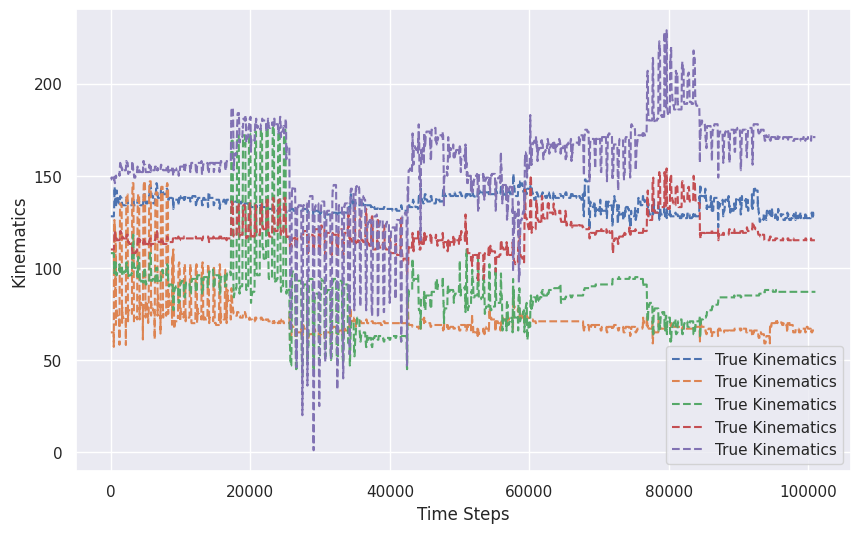

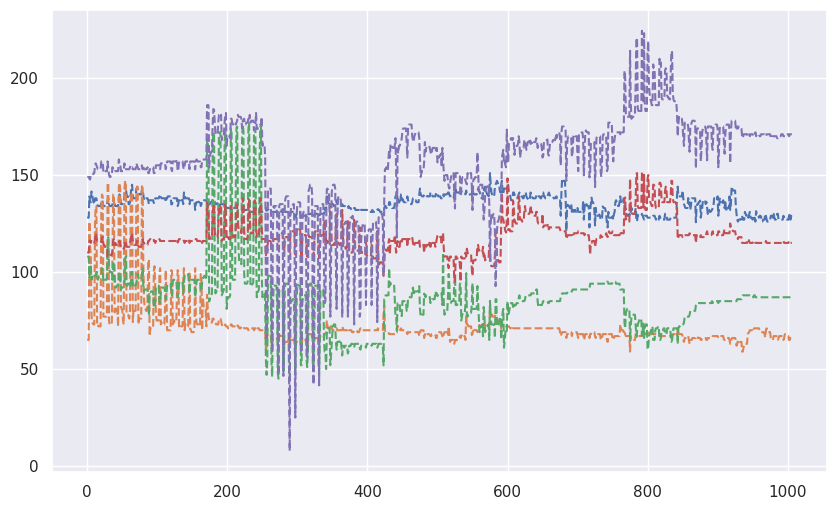

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(angle, label="True Kinematics", linestyle="--")
plt.xlabel("Time Steps")
plt.ylabel("Kinematics")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(targets, label="Kinematics", linestyle="--")
plt.show()


In [33]:
print(features.shape)
print(targets.shape)

(1007, 60)
(1007, 5)


In [37]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# 数据划分：训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

# 使用 MultiOutputRegressor 包装 GradientBoostingRegressor
base_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
multioutput_model = MultiOutputRegressor(base_model)

# 训练模型
multioutput_model.fit(X_train, y_train)

# 预测
Y_pred = multioutput_model.predict(X_test)

# 模型评估
mse = mean_squared_error(y_test, Y_pred, multioutput='raw_values')  # 计算每个输出的 MSE
r2 = r2_score(y_test, Y_pred, multioutput='uniform_average')  # 平均 R²

print("模型评估结果：")
print(f"每个输出的均方误差 (MSE): {mse}")
print(f"平均决定系数 (R²): {r2:.4f}")

模型评估结果：
每个输出的均方误差 (MSE): [  9.0479331   63.45824255  58.94135243  18.02858785 154.28193477]
平均决定系数 (R²): 0.7296


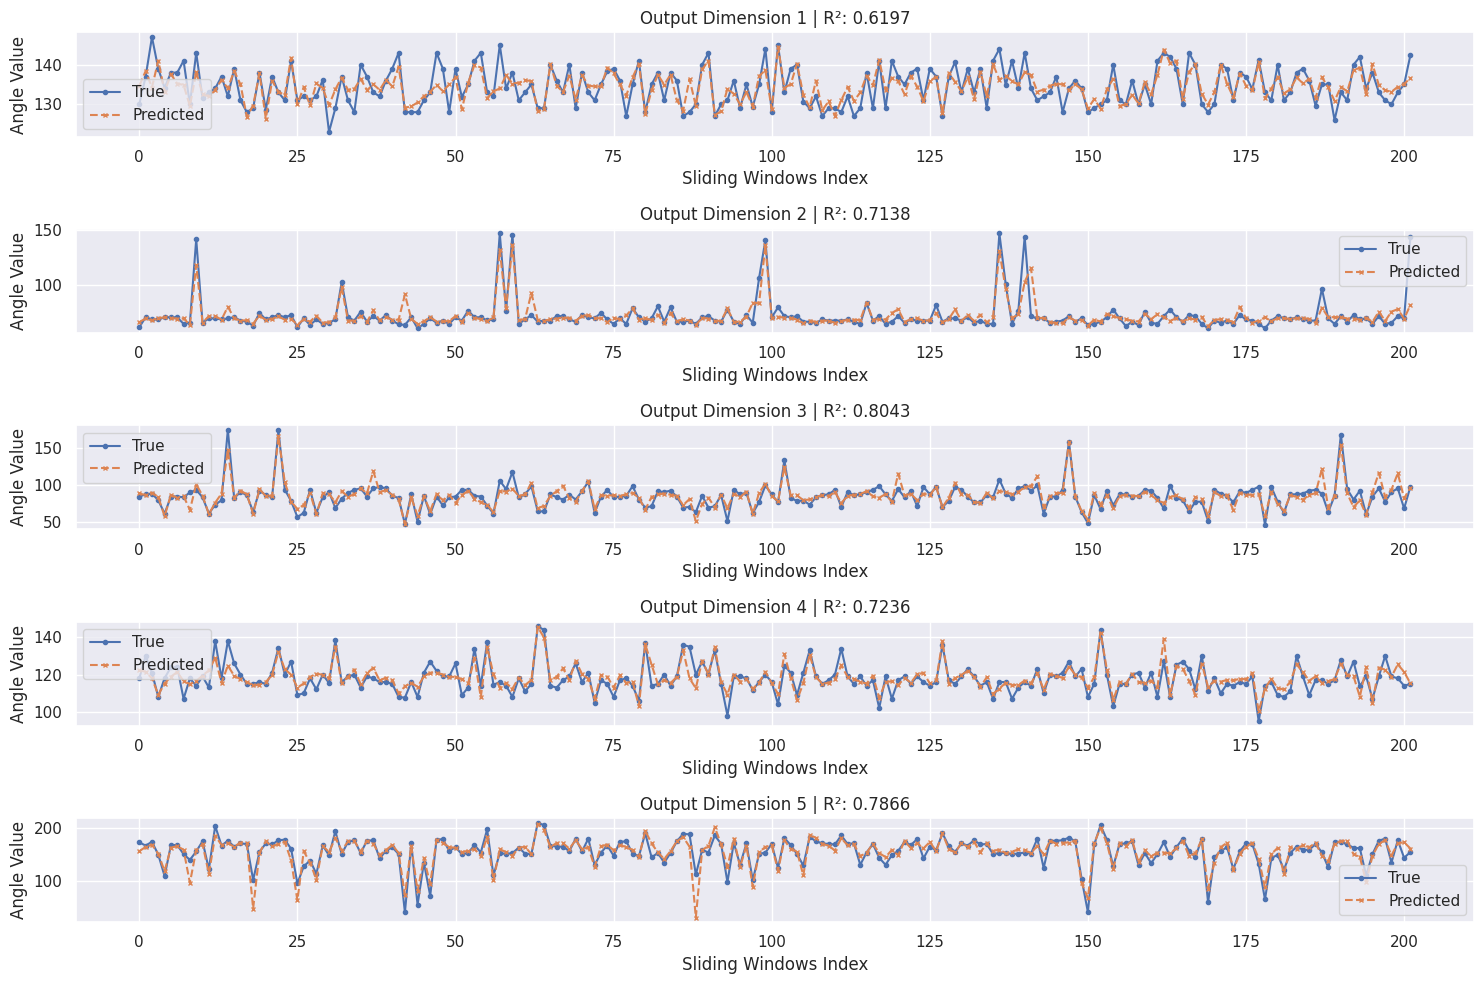

In [43]:
def plot_predictions_with_metrics(Y_test, Y_pred, num_outputs):
    """
    绘制真实值与预测值的比较图，并在每个子图上显示 R² 和 MSE。
    :param Y_test: 真实标签 (n_samples, num_outputs)
    :param Y_pred: 预测值 (n_samples, num_outputs)
    :param num_outputs: 输出维度数量
    """
    plt.figure(figsize=(15, 10))

    for i in range(num_outputs):
        # 计算 R² 和 MSE
        r2 = r2_score(Y_test[:, i], Y_pred[:, i])
        # mse = mean_squared_error(Y_test[:, i], Y_pred[:, i])

        # 绘制真实值和预测值
        plt.subplot(num_outputs, 1, i + 1)
        plt.plot(Y_test[:, i], label='True', linestyle='-', marker='o', markersize=3)
        plt.plot(Y_pred[:, i], label='Predicted', linestyle='--', marker='x', markersize=3)

        # 添加标题和指标
        plt.title(f"Output Dimension {i+1} | R²: {r2:.4f}")
        plt.xlabel("Sliding Windows Index")
        plt.ylabel("Angle Value")
        plt.legend()
        plt.tight_layout()

    plt.show()

# 调用函数
plot_predictions_with_metrics(y_test, Y_pred, num_outputs=y_test.shape[1])